# Figure 1 - предварительные результаты

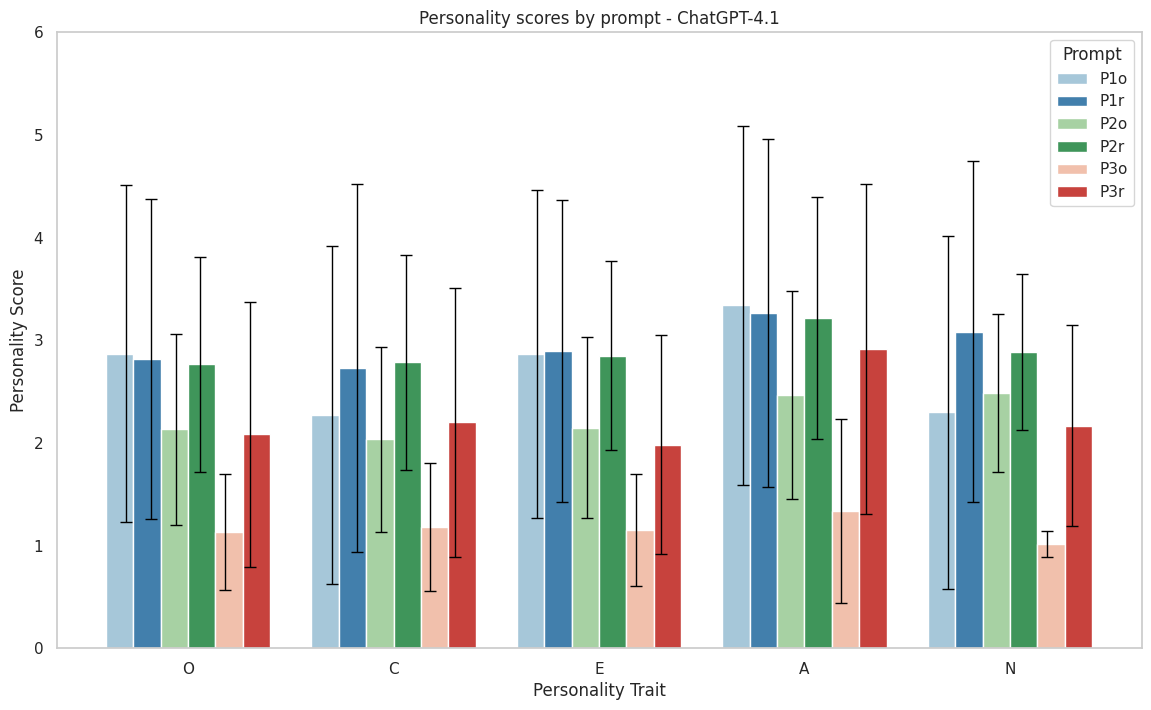

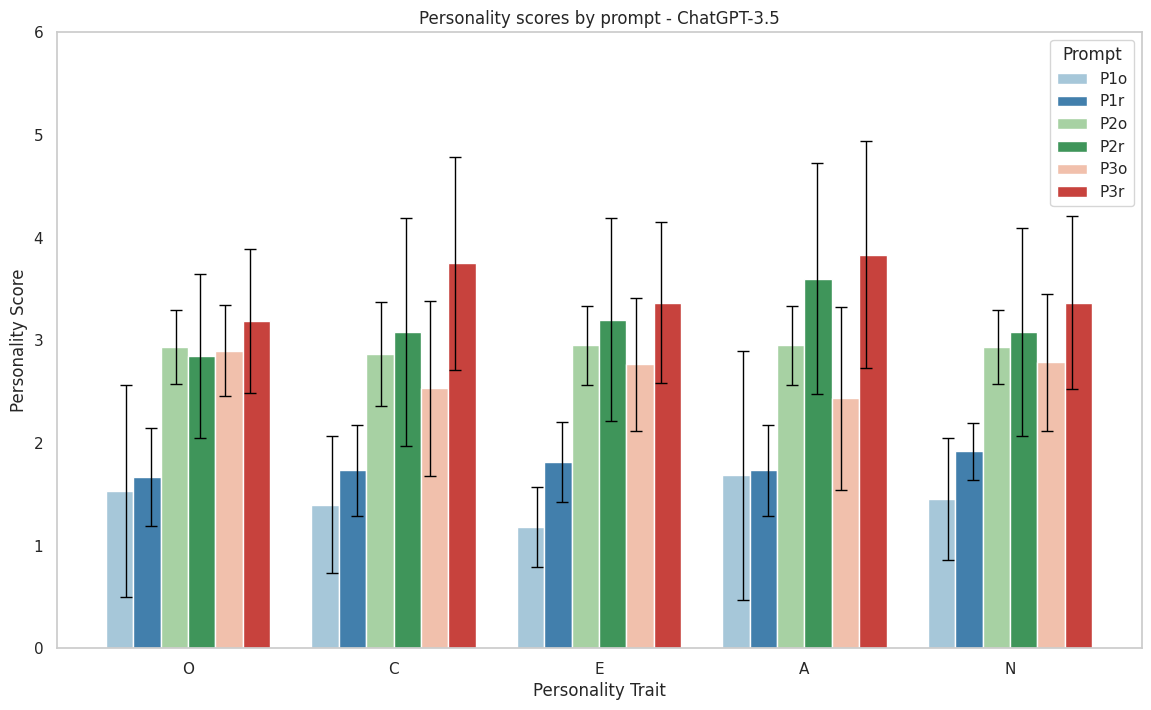

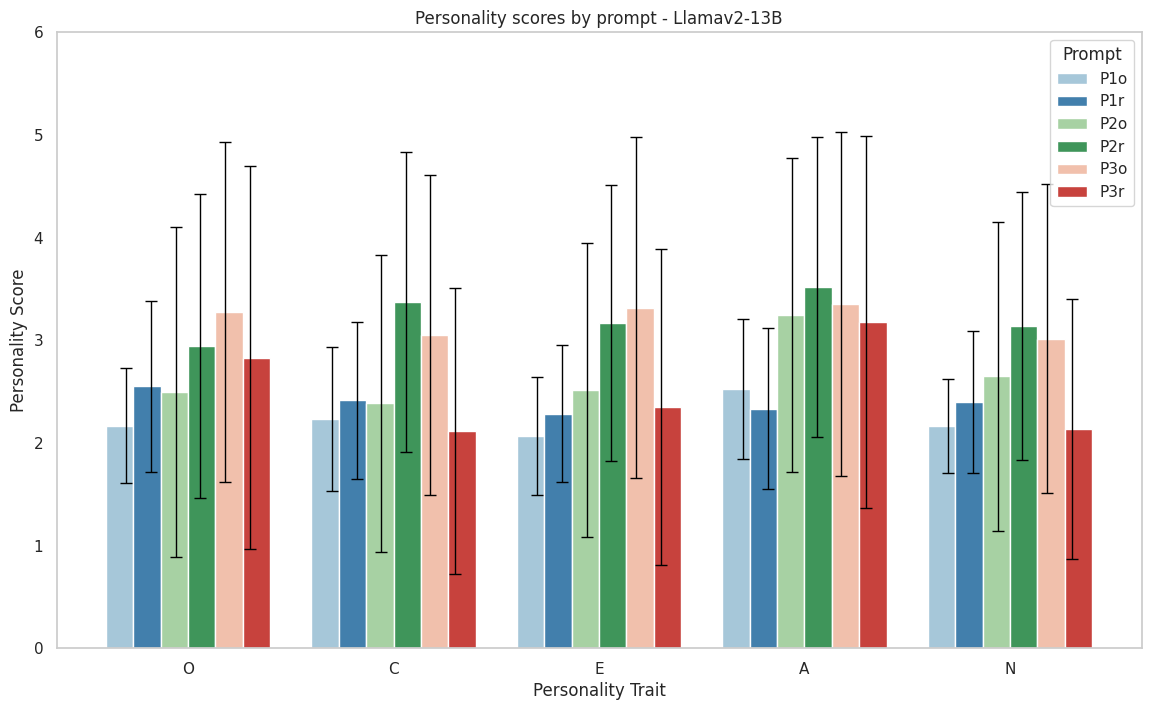

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

files = {
    'ChatGPT-4.1': 'GPT-4.1.csv',
    'ChatGPT-3.5': 'GPT-3.5.csv',
    'Llamav2-13B': 'llama-2-13b.csv'
}

# Порядок промптов
prompts = ['P1o', 'P1r', 'P2o', 'P2r', 'P3o', 'P3r']

# Настраиваем цвета как в статье
prompt_colors = {
    'P1o': '#9ecae1',
    'P1r': '#3182bd',
    'P2o': '#a1d99b',
    'P2r': '#31a354',
    'P3o': '#fcbba1',
    'P3r': '#de2d26'
}

for model_name, file_path in files.items():
    df = pd.read_csv(file_path, sep=',')
    df = df.dropna(axis=0, how='all')

    summary = []

    for trait in ['O', 'C', 'E', 'A', 'N']:
        trait_df = df[df['Label'] == trait]
        for prompt in prompts:
            if prompt in trait_df.columns:
                values = pd.to_numeric(trait_df[prompt], errors='coerce')
                mean = values.mean(skipna=True)
                std = values.std(skipna=True)
                summary.append({'Trait': trait, 'Prompt': prompt, 'Mean': mean, 'Std': std})

    summary_df = pd.DataFrame(summary)

    plt.figure(figsize=(14, 8))

    # Генерация цветов в нужном порядке
    colors = [prompt_colors[p] for p in summary_df['Prompt']]

    ax = sns.barplot(
        data=summary_df,
        x='Trait',
        y='Mean',
        hue='Prompt',
        palette=prompt_colors,
        dodge=True,
        errorbar=None
    )

    # Error bars вручную
    n_traits = len(summary_df['Trait'].unique())
    n_prompts = len(prompts)
    offsets = np.linspace(-0.3, 0.3, n_prompts)
    width = offsets[1] - offsets[0]

    for i, trait in enumerate(['O', 'C', 'E', 'A', 'N']):
        for j, prompt in enumerate(prompts):
            subset = summary_df[(summary_df['Trait'] == trait) & (summary_df['Prompt'] == prompt)]
            if not subset.empty:
                mean = subset['Mean'].values[0]
                std = subset['Std'].values[0]
                x_position = i + offsets[j]
                plt.errorbar(
                    x=x_position,
                    y=mean,
                    yerr=std,
                    fmt='none',
                    ecolor='black',
                    capsize=4,
                    elinewidth=1
                )

    plt.title(f'Personality scores by prompt - {model_name}')
    plt.ylabel('Personality Score')
    plt.ylim(0, 6)
    plt.xlabel('Personality Trait')
    plt.xticks(ticks=range(5), labels=['O', 'C', 'E', 'A', 'N'])
    plt.grid(axis='y')
    plt.legend(title='Prompt', loc='upper right')
    plt.show()

# Figure 2 - статистические тесты

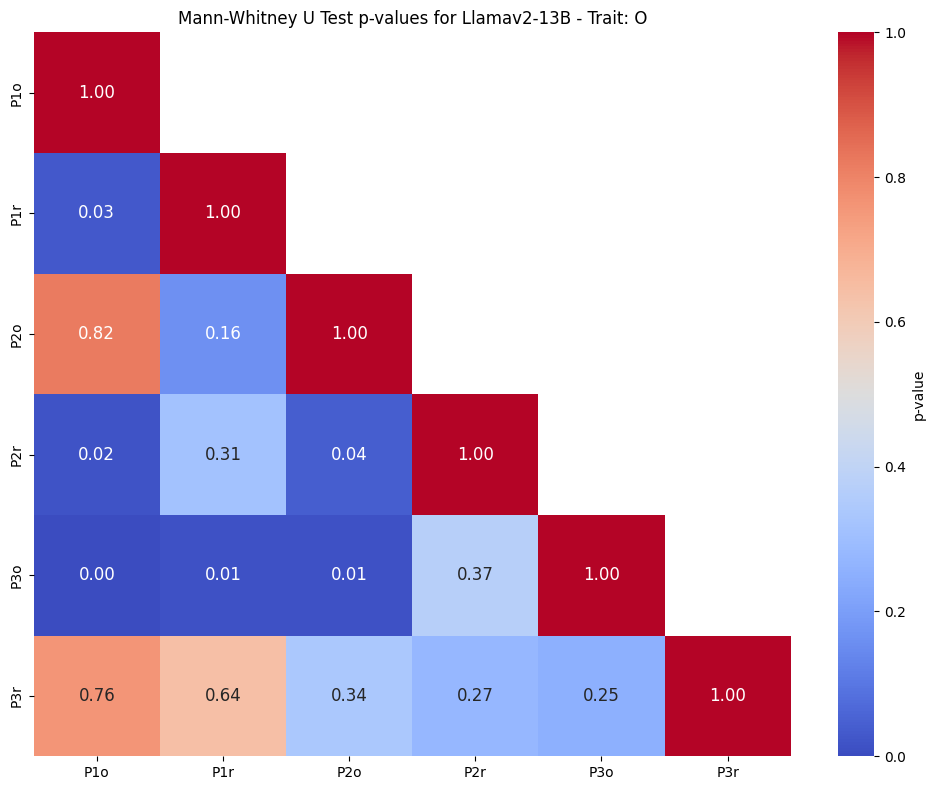

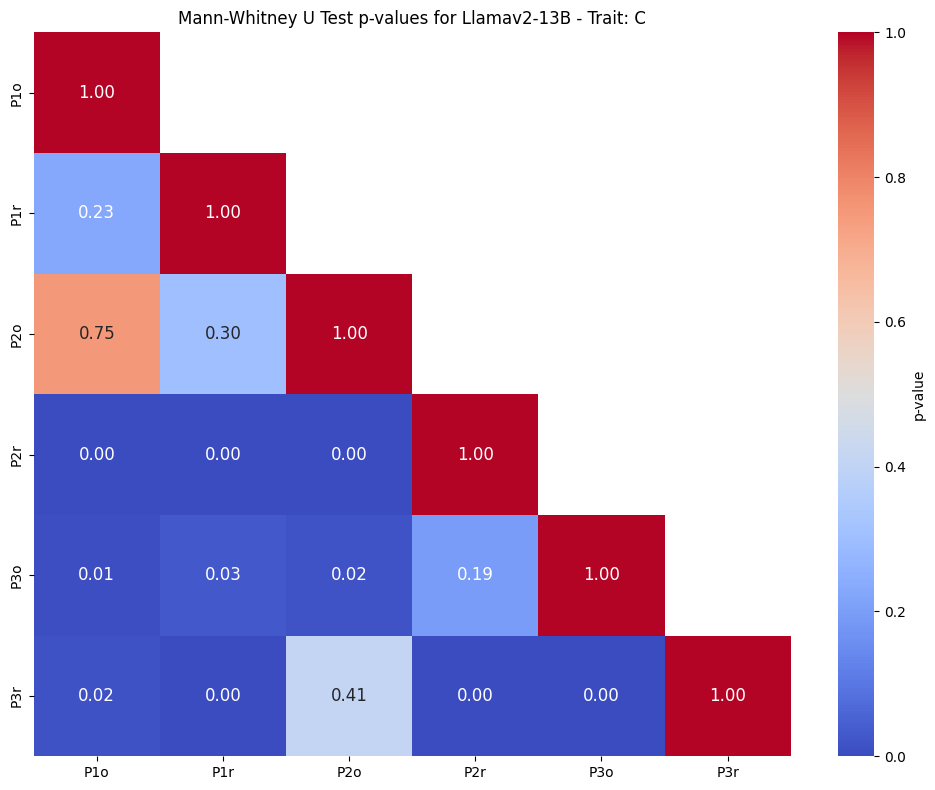

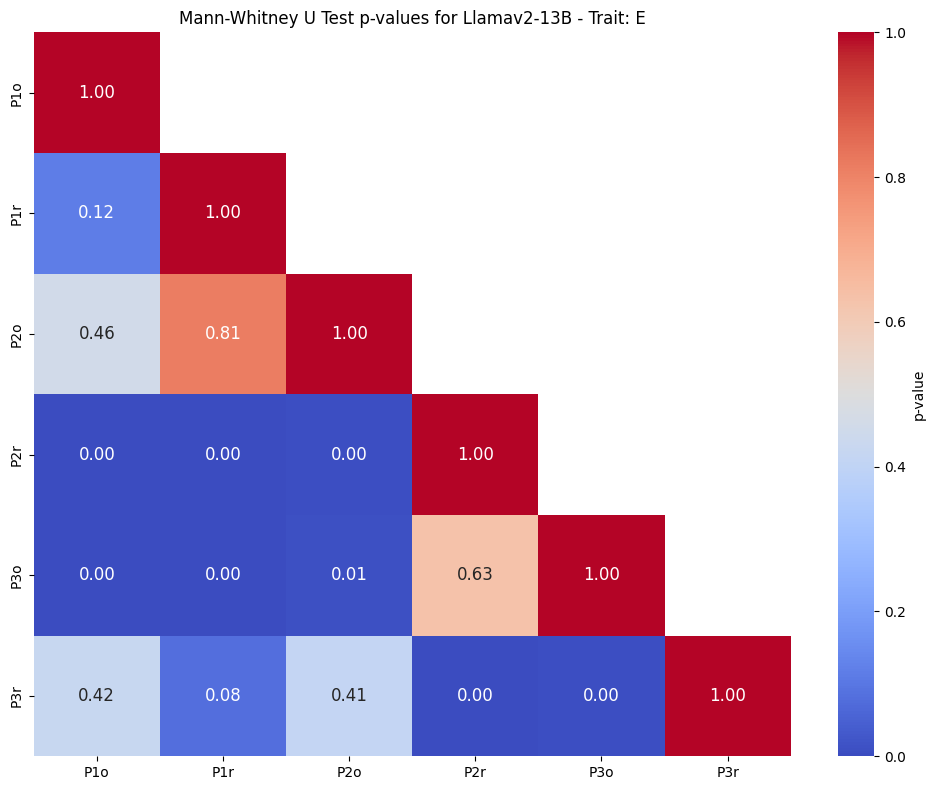

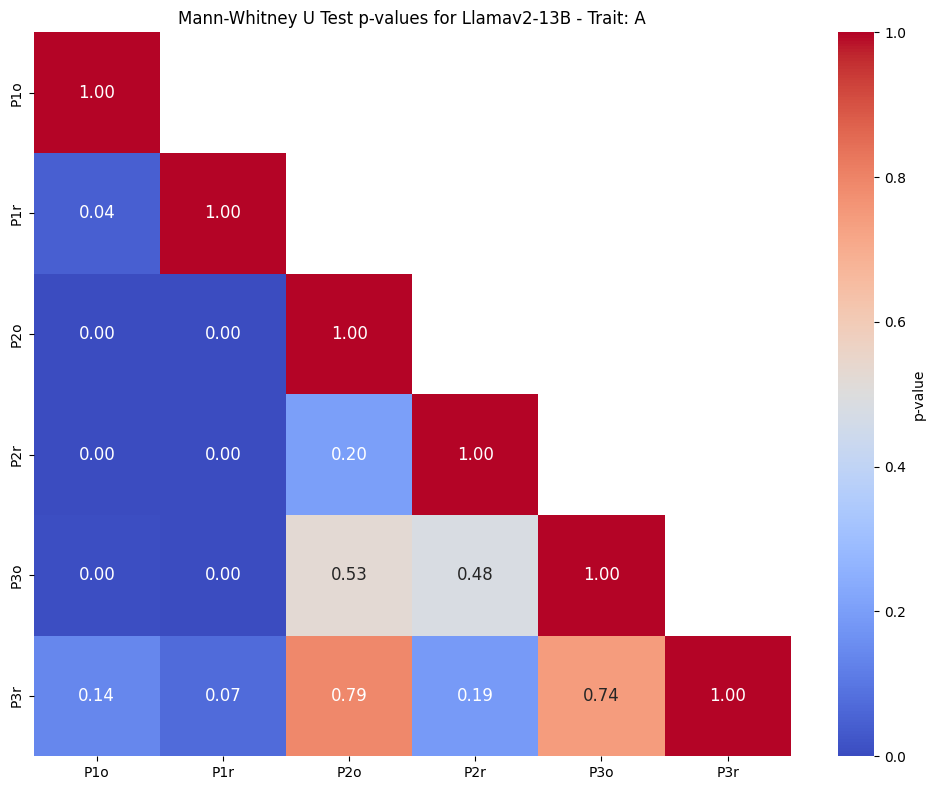

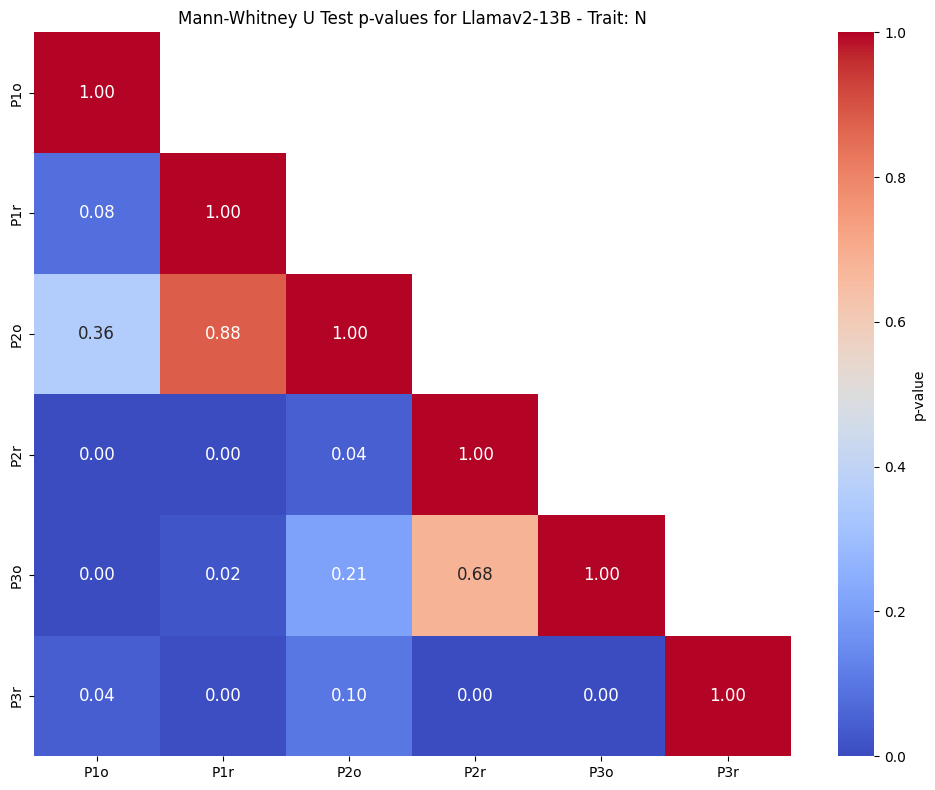

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import os
import warnings

def analyze_model(input_csv_path, model_name, stats_output_csv_path):
    df = pd.read_csv(input_csv_path, sep=",")
    prompt_columns = ['P1o', 'P1r', 'P2o', 'P2r', 'P3o', 'P3r']

    # Заменяем пустые строки на NaN
    df[prompt_columns] = df[prompt_columns].replace(r'^\s*$', np.nan, regex=True)

    traits = df['Label'].unique()
    all_stats = []

    for trait in traits:
        df_trait = df[df['Label'] == trait]

        p_values = np.zeros((len(prompt_columns), len(prompt_columns)))

        for i, col1 in enumerate(prompt_columns):
            for j, col2 in enumerate(prompt_columns):
                if i == j:
                    p_values[i, j] = 1.00
                elif i > j:
                    # Очищаем NaN для каждой пары отдельно
                    col1_clean = df_trait[col1].dropna()
                    col2_clean = df_trait[col2].dropna()

                    try:
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            u_stat, p_val = mannwhitneyu(col1_clean, col2_clean, alternative='two-sided')
                    except Exception as e:
                        print(f"Warning: {col1} vs {col2} caused error: {e}")
                        p_val = 1.0

                    if np.isnan(p_val):
                        print(f"Warning: {col1} vs {col2} resulted in NaN p-value. Forcing p=1.0")
                        p_val = 1.0

                    p_values[i, j] = p_val

                    all_stats.append({
                        "Model": model_name,
                        "Trait": trait,
                        "Prompt1": col1,
                        "Prompt2": col2,
                        "P_value": p_val,
                        "Reject_null": int(p_val < 0.05)
                    })
                else:
                    p_values[i, j] = np.nan

        plt.figure(figsize=(10,8))
        sns.heatmap(
            p_values,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=0, vmax=1,
            mask=np.isnan(p_values),
            xticklabels=prompt_columns,
            yticklabels=prompt_columns,
            cbar_kws={'label': 'p-value'},
            annot_kws={"size": 12}
        )
        plt.title(f'Mann-Whitney U Test p-values for {model_name} - Trait: {trait}')
        plt.tight_layout()

        os.makedirs('plots', exist_ok=True)
        plt.savefig(f"plots/{model_name}_{trait}_heatmap.png")
        plt.show()
        plt.close()

    stats_df = pd.DataFrame(all_stats)

    if os.path.exists(stats_output_csv_path):
        stats_df.to_csv(stats_output_csv_path, mode='a', header=False, index=False)
    else:
        stats_df.to_csv(stats_output_csv_path, index=False)

analyze_model(
    input_csv_path="llama-2-13b.csv",
    model_name="Llamav2-13B",
    stats_output_csv_path="summary.csv"
)

# Figure 3 - итоговые выводы по статистическим тестам

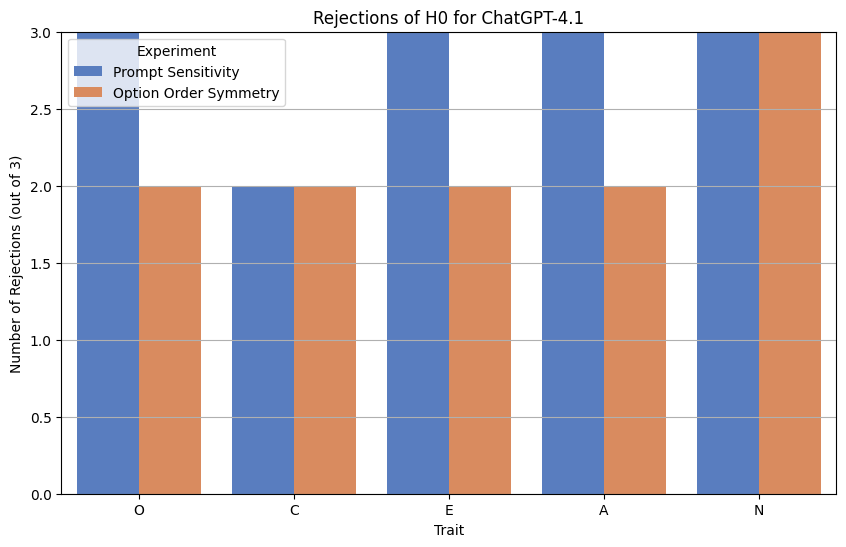

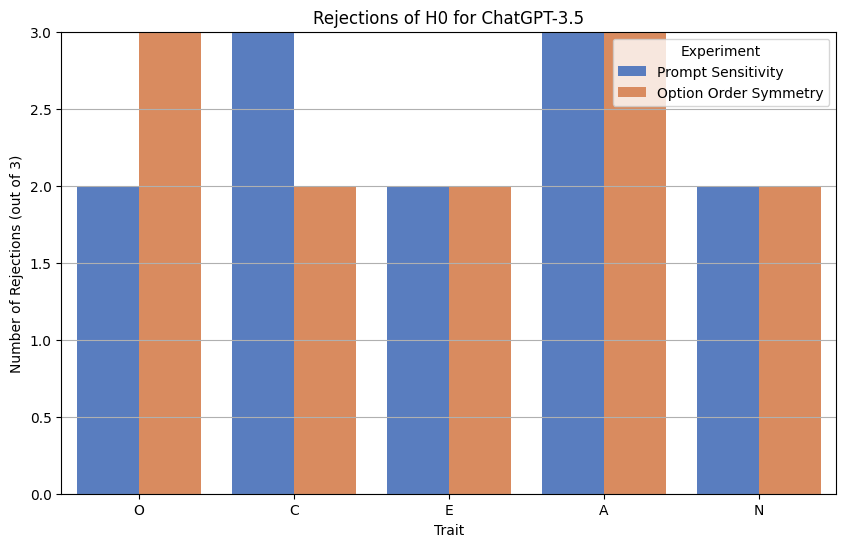

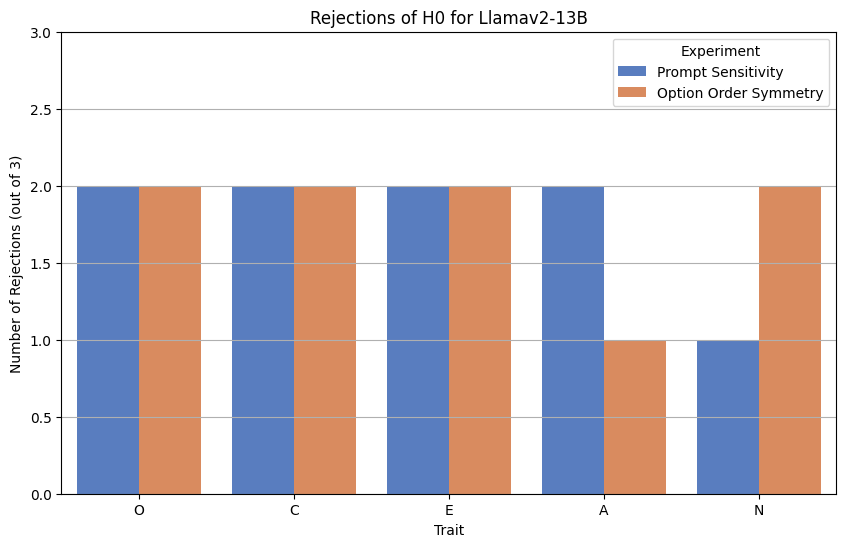

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'summary.csv'
df = pd.read_csv(file_path, sep=',')

# Пары промптов для двух экспериментов
exp1_pairs = [('P1o', 'P2o'), ('P1o', 'P3o'), ('P2o', 'P3o')]
exp2_pairs = [('P1o', 'P1r'), ('P2o', 'P2r'), ('P3o', 'P3r')]

def get_rejections_per_experiment(df, model, exp_pairs, exp_name):
    results = []
    model_df = df[df['Model'] == model]
    for trait in model_df['Trait'].unique():
        trait_df = model_df[model_df['Trait'] == trait]
        rejections = 0
        for p1, p2 in exp_pairs:
            match = trait_df[((trait_df['Prompt1'] == p1) & (trait_df['Prompt2'] == p2)) |
                             ((trait_df['Prompt1'] == p2) & (trait_df['Prompt2'] == p1))]
            if not match.empty and match['Reject_null'].values[0] == 1:
                rejections += 1
        results.append({'Trait': trait, 'Experiment': exp_name, 'Rejections': rejections})
    return pd.DataFrame(results)

models = df['Model'].unique()
all_results = {}

for model in models:
    exp1_data = get_rejections_per_experiment(df, model, exp1_pairs, 'Prompt Sensitivity')
    exp2_data = get_rejections_per_experiment(df, model, exp2_pairs, 'Option Order Symmetry')
    model_result = pd.concat([exp1_data, exp2_data])
    all_results[model] = model_result

for model, plot_df in all_results.items():
    plt.figure(figsize=(10, 6))
    sns.barplot(data=plot_df, x='Trait', y='Rejections', hue='Experiment', palette='muted')
    plt.title(f'Rejections of H0 for {model}')
    plt.ylim(0, 3)  # максимум отказов может быть 3
    plt.ylabel('Number of Rejections (out of 3)')
    plt.xlabel('Trait')
    plt.grid(axis='y')
    plt.legend(title='Experiment')
    plt.show()
